In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import *
from sklearn.preprocessing import StandardScaler
from sklearn_features.transformers import DataFrameSelector
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import phik
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

## Оглавление   
1. [Загрузка данных](#1)  
2. [Исследование данных](#2)   
3. [Кластеризация покупателей](#3)   
4. [Подготовка данных для предсказания периода покупательской активности](#4)    
5. [Обучение](#5)


## Загрузка данных
<a id="1"></a>

In [2]:
orders=pd.read_csv('olist_orders_dataset.csv')
display(orders.head())

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [3]:
cust=pd.read_csv('olist_customers_dataset.csv')
cust.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
items=pd.read_csv('olist_order_items_dataset.csv')
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [5]:
geo=pd.read_csv('olist_geolocation_dataset.csv')
geo.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [6]:
payment=pd.read_csv('olist_order_payments_dataset.csv')
payment.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [7]:
df=orders.merge(payment, on='order_id')
df=df.merge(cust, on='customer_id')

In [8]:
display(df.head())
print("Таблица содержит {:.0f} дубликатов".format(df.duplicated().sum()))

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3,voucher,1,2.00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2,voucher,1,18.59,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,boleto,1,141.46,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1,credit_card,3,179.12,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO


Таблица содержит 0 дубликатов


## 2. Исследование данных
<a id="2"></a>

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [10]:
orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [11]:
orders['order_purchase_timestamp']=pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_carrier_date']=pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_customer_date']=pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date']=pd.to_datetime(orders['order_estimated_delivery_date'])

In [12]:
payment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [13]:
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

In [14]:
#Создание сводной таблицы по активности покупателей
df_pivot=df.query('order_status=="delivered"').pivot_table(index='customer_unique_id', values='order_id', aggfunc='nunique').reset_index()

In [15]:
df_pivot=df_pivot.merge(df.pivot_table(index='customer_unique_id', values='payment_value', aggfunc='sum').reset_index(),
                       on='customer_unique_id')
df_pivot=df_pivot.merge(df.pivot_table(index='customer_unique_id', values='order_purchase_timestamp', aggfunc='min').reset_index().rename(columns={'order_purchase_timestamp':'first_order'}),
                       on='customer_unique_id')
df_pivot=df_pivot.merge(df.pivot_table(index='customer_unique_id', values='order_purchase_timestamp', aggfunc='max').reset_index().rename(columns={'order_purchase_timestamp':'last_order'}),
                       on='customer_unique_id')

In [16]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93357 entries, 0 to 93356
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  93357 non-null  object 
 1   order_id            93357 non-null  int64  
 2   payment_value       93357 non-null  float64
 3   first_order         93357 non-null  object 
 4   last_order          93357 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 4.3+ MB


In [17]:
df_pivot['first_order']=pd.to_datetime(df_pivot['first_order'])
df_pivot['last_order']=pd.to_datetime(df_pivot['last_order'])

In [18]:
from datetime import time, timedelta 
df_pivot['days_in_shop']=df_pivot.last_order-df_pivot.first_order
df_pivot['days_in_shop']=df_pivot['days_in_shop'].dt.days

In [19]:
df_pivot

,customer_unique_id,order_id,payment_value,first_order,last_order,days_in_shop
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,2018-05-10 10:56:27,2018-05-10 10:56:27,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,2018-05-07 11:11:27,2018-05-07 11:11:27,0
2,0000f46a3911fa3c0805444483337064,1,86.22,2017-03-10 21:05:03,2017-03-10 21:05:03,0
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,2017-10-12 20:29:41,2017-10-12 20:29:41,0
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,2017-11-14 19:45:42,2017-11-14 19:45:42,0
...,...,...,...,...,...,...
93352,fffcf5a5ff07b0908bd4e2dbc735a684,1,2067.42,2017-06-08 21:00:36,2017-06-08 21:00:36,0
93353,fffea47cd6d3cc0a88bd621562a9d061,1,84.58,2017-12-10 20:07:56,2017-12-10 20:07:56,0
93354,ffff371b4d645b6ecea244b27531430a,1,112.46,2017-02-07 15:49:16,2017-02-07 15:49:16,0
93355,ffff5962728ec6157033ef9805bacc48,1,133.69,2018-05-02 15:17:41,2018-05-02 15:17:41,0


In [20]:
df_pivot.query('days_in_shop>0')

,customer_unique_id,order_id,payment_value,first_order,last_order,days_in_shop
33,00172711b30d52eea8b313a7f2cced02,1,244.14,2018-07-28 00:23:49,2018-08-13 09:14:07,16
104,004288347e5e88a27ded2bb23747066c,2,354.37,2017-07-27 14:13:03,2018-01-14 07:36:54,170
121,004b45ec5c64187465168251cd1c9c2f,1,147.72,2017-09-01 12:11:23,2018-05-26 19:42:48,267
141,0058f300f57d7b93c477a131a59b36c3,1,175.58,2018-02-19 17:11:34,2018-03-22 18:09:41,31
243,00a39521eb40f7012db50455bf083460,2,123.25,2018-05-23 20:14:21,2018-06-03 10:12:57,10
...,...,...,...,...,...,...
92817,fe81bb32c243a86b2f86fbf053fe6140,5,1590.76,2017-10-22 11:29:22,2018-06-21 12:10:25,242
92922,fed519569d16e690df6f89cb99d4e682,2,286.14,2017-12-20 19:10:19,2018-03-18 21:51:49,88
92990,ff03923ad1eb9e32304deb7f9b2a45c9,2,247.06,2018-04-23 21:49:49,2018-05-26 11:51:22,32
93186,ff8892f7c26aa0446da53d01b18df463,2,330.14,2017-05-24 16:09:14,2017-11-26 23:25:43,186


In [21]:
df_pivot['month_in_shop']=df_pivot['days_in_shop']/30

In [22]:
df_pivot[df_pivot['month_in_shop']>0]

,customer_unique_id,order_id,payment_value,first_order,last_order,days_in_shop,month_in_shop
33,00172711b30d52eea8b313a7f2cced02,1,244.14,2018-07-28 00:23:49,2018-08-13 09:14:07,16,0.533333
104,004288347e5e88a27ded2bb23747066c,2,354.37,2017-07-27 14:13:03,2018-01-14 07:36:54,170,5.666667
121,004b45ec5c64187465168251cd1c9c2f,1,147.72,2017-09-01 12:11:23,2018-05-26 19:42:48,267,8.900000
141,0058f300f57d7b93c477a131a59b36c3,1,175.58,2018-02-19 17:11:34,2018-03-22 18:09:41,31,1.033333
243,00a39521eb40f7012db50455bf083460,2,123.25,2018-05-23 20:14:21,2018-06-03 10:12:57,10,0.333333
...,...,...,...,...,...,...,...
92817,fe81bb32c243a86b2f86fbf053fe6140,5,1590.76,2017-10-22 11:29:22,2018-06-21 12:10:25,242,8.066667
92922,fed519569d16e690df6f89cb99d4e682,2,286.14,2017-12-20 19:10:19,2018-03-18 21:51:49,88,2.933333
92990,ff03923ad1eb9e32304deb7f9b2a45c9,2,247.06,2018-04-23 21:49:49,2018-05-26 11:51:22,32,1.066667
93186,ff8892f7c26aa0446da53d01b18df463,2,330.14,2017-05-24 16:09:14,2017-11-26 23:25:43,186,6.200000


In [23]:
df_pivot['orders_per_month']=df_pivot.order_id/df_pivot.month_in_shop
df_pivot['revenue_per_month']=df_pivot.payment_value/df_pivot.month_in_shop

In [24]:
df_pivot

,customer_unique_id,order_id,payment_value,first_order,last_order,days_in_shop,month_in_shop,orders_per_month,revenue_per_month
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,2018-05-10 10:56:27,2018-05-10 10:56:27,0,0.0,inf,inf
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,2018-05-07 11:11:27,2018-05-07 11:11:27,0,0.0,inf,inf
2,0000f46a3911fa3c0805444483337064,1,86.22,2017-03-10 21:05:03,2017-03-10 21:05:03,0,0.0,inf,inf
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,2017-10-12 20:29:41,2017-10-12 20:29:41,0,0.0,inf,inf
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,2017-11-14 19:45:42,2017-11-14 19:45:42,0,0.0,inf,inf
...,...,...,...,...,...,...,...,...,...
93352,fffcf5a5ff07b0908bd4e2dbc735a684,1,2067.42,2017-06-08 21:00:36,2017-06-08 21:00:36,0,0.0,inf,inf
93353,fffea47cd6d3cc0a88bd621562a9d061,1,84.58,2017-12-10 20:07:56,2017-12-10 20:07:56,0,0.0,inf,inf
93354,ffff371b4d645b6ecea244b27531430a,1,112.46,2017-02-07 15:49:16,2017-02-07 15:49:16,0,0.0,inf,inf
93355,ffff5962728ec6157033ef9805bacc48,1,133.69,2018-05-02 15:17:41,2018-05-02 15:17:41,0,0.0,inf,inf


## Кластеризация покупателей
<a id="3"></a>

In [25]:
df_pivot=df_pivot.rename(columns={'order_id':'amount_orders'})

In [26]:
df_pivot.columns

Index(['customer_unique_id', 'amount_orders', 'payment_value', 'first_order',
       'last_order', 'days_in_shop', 'month_in_shop', 'orders_per_month',
       'revenue_per_month'],
      dtype='object')

In [27]:
df2=df_pivot[['payment_value', 'amount_orders', 'days_in_shop']].copy()

In [28]:
df2['avg_check']=df_pivot.payment_value/df_pivot.amount_orders

In [29]:
df2['payment_value']=round(df2['payment_value'], -2)

In [30]:
df2['payment_value']=df2['payment_value'].astype('int')

In [31]:
df2['avg_check']=round(df2['avg_check'],-1)

In [32]:
df2['avg_check']=df2['avg_check'].astype('int')

In [33]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93357 entries, 0 to 93356
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   payment_value  93357 non-null  int32
 1   amount_orders  93357 non-null  int64
 2   days_in_shop   93357 non-null  int64
 3   avg_check      93357 non-null  int32
dtypes: int32(2), int64(2)
memory usage: 2.8 MB


array([[<AxesSubplot:title={'center':'payment_value'}>,
        <AxesSubplot:title={'center':'amount_orders'}>],
       [<AxesSubplot:title={'center':'days_in_shop'}>,
        <AxesSubplot:title={'center':'avg_check'}>]], dtype=object)

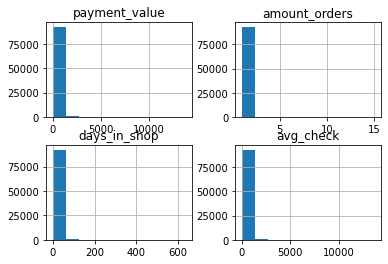

In [34]:
df2.hist()

In [35]:
#df2=df2.drop_duplicates()

In [36]:
df2.describe()

,payment_value,amount_orders,days_in_shop,avg_check
count,93357.000000,93357.000000,93357.000000,93357.000000
mean,165.280590,1.033420,2.788779,160.835502
std,231.341605,0.209099,25.757729,222.365044
min,0.000000,1.000000,0.000000,10.000000
25%,100.000000,1.000000,0.000000,60.000000
50%,100.000000,1.000000,0.000000,110.000000
75%,200.000000,1.000000,0.000000,180.000000
max,13700.000000,15.000000,633.000000,13660.000000


In [37]:
list_col=df2.columns

In [38]:
df3=df2[:2000].copy()
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   payment_value  2000 non-null   int32
 1   amount_orders  2000 non-null   int64
 2   days_in_shop   2000 non-null   int64
 3   avg_check      2000 non-null   int32
dtypes: int32(2), int64(2)
memory usage: 62.5 KB


In [39]:
x_sc=StandardScaler().fit_transform(df2)

При помощи метода иерархической кластеризации была произведена оценка количества кластеров для задания в методе к-средних

In [40]:
km=KMeans(n_clusters=4)
labels=km.fit_predict(x_sc)
df2['cluster']=labels#вывод статистики по средним значениям признаков по кластеру
df2.groupby(['cluster']).median()

,payment_value,amount_orders,days_in_shop,avg_check
cluster,,,,
0,800,1.0,0.0,810
1,200,2.0,12.0,110
2,200,2.0,246.5,120
3,100,1.0,0.0,100


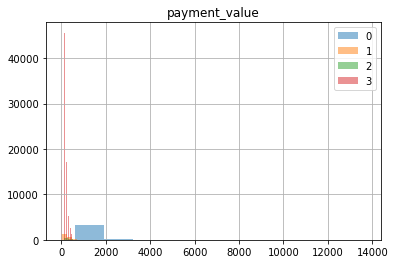

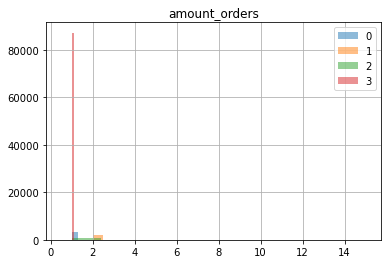

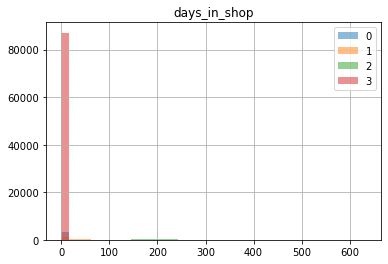

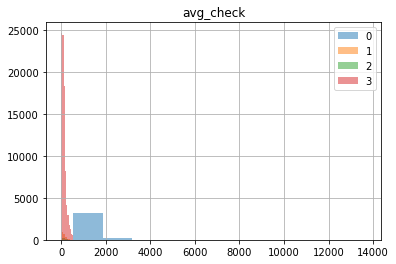

In [41]:
for i in list_col:
    df2.groupby('cluster')[i].hist(alpha=0.5)
    plt.legend(set(df2['cluster']))
    plt.title(i)
    plt.show()

In [42]:
display(df2.groupby(['cluster']).describe(), pd.set_option('display.max_columns', None))

payment_value                                                        \
                count         mean         std    min    25%    50%     75%   
cluster                                                                       
0              3398.0  1006.150677  640.581649  600.0  600.0  800.0  1100.0   
1              2119.0   280.840019  215.414159    0.0  100.0  200.0   300.0   
2               688.0   326.744186  266.597263  100.0  200.0  200.0   400.0   
3             87152.0   128.411281  100.939399    0.0  100.0  100.0   200.0   

                 amount_orders                                                \
             max         count      mean       std  min  25%  50%  75%   max   
cluster                                                                        
0        13700.0        3398.0  1.008240  0.099704  1.0  1.0  1.0  1.0   4.0   
1         2400.0        2119.0  2.067013  0.304580  2.0  2.0  2.0  2.0   7.0   
2         2200.0         688.0  2.207849  0.885988  1.0  2.0  2.0  2.0  15.0   
3          500.0       87152.0  1.000000  0.000000  1.0  1.0  1.0  1.0   1.0   

        days_in_shop                                                      \
               count        mean        std    min    25%    50%     75%   
cluster                                                                    
0             3398.0    0.241024   3.876045    0.0    0.0    0.0    0.00   
1             2119.0   33.264276  42.597009    0.0    0.0   12.0   57.00   
2              688.0  269.731105  94.094112  145.0  194.0  246.5  327.25   
3            87152.0    0.039827   1.814879    0.0    0.0    0.0    0.00   

               avg_check                                                       \
           max     count        mean         std    min    25%    50%     75%   
cluster                                                                         
0        161.0    3398.0  996.962919  624.735789  550.0  650.0  810.0  1120.0   
1        153.0    2119.0  135.932043  100.716353   20.0   70.0  110.0   170.0   
2        633.0     688.0  150.072674  111.202874   30.0   80.0  120.0   180.0   
3        169.0   87152.0  128.925900   95.484598   10.0   60.0  100.0   170.0   

                  
             max  
cluster           
0        13660.0  
1          800.0  
2          730.0  
3          550.0

None

По результатам кластеризации можно разделить покупателей на 4 группы:   
**1.** Новые покупатели, совершившие покупку впервые на крупную сумму   
**2.** Новые покупатели, совершившие покупку впервые на небольшую сумму   
**3.** Покупатели, совершившие повторную покупку в течении 2 месяцев   
**4.** Покупатели, совершившие повторную покупку в период от 4 до 12 месяцев

## Подготовка данных для предсказания периода покупательской активности
<a id="4"></a>

In [43]:
#исходный датасет
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103886 entries, 0 to 103885
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       103886 non-null  object 
 1   customer_id                    103886 non-null  object 
 2   order_status                   103886 non-null  object 
 3   order_purchase_timestamp       103886 non-null  object 
 4   order_approved_at              103711 non-null  object 
 5   order_delivered_carrier_date   101998 non-null  object 
 6   order_delivered_customer_date  100754 non-null  object 
 7   order_estimated_delivery_date  103886 non-null  object 
 8   payment_sequential             103886 non-null  int64  
 9   payment_type                   103886 non-null  object 
 10  payment_installments           103886 non-null  int64  
 11  payment_value                  103886 non-null  float64
 12  customer_unique_id            

In [44]:
df_pivot=df_pivot.rename(columns={'payment_value':'sum_payment_value'})

In [45]:
df_pivot['first_order_month']=pd.DatetimeIndex(df_pivot['first_order']).month
df_pivot['first_order_year']=pd.DatetimeIndex(df_pivot['first_order']).year
df_pivot['last_order_month']=pd.DatetimeIndex(df_pivot['last_order']).month
df_pivot['last_order_year']=pd.DatetimeIndex(df_pivot['last_order']).year

In [46]:
#сводный датасет
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93357 entries, 0 to 93356
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_unique_id  93357 non-null  object        
 1   amount_orders       93357 non-null  int64         
 2   sum_payment_value   93357 non-null  float64       
 3   first_order         93357 non-null  datetime64[ns]
 4   last_order          93357 non-null  datetime64[ns]
 5   days_in_shop        93357 non-null  int64         
 6   month_in_shop       93357 non-null  float64       
 7   orders_per_month    93357 non-null  float64       
 8   revenue_per_month   93357 non-null  float64       
 9   first_order_month   93357 non-null  int64         
 10  first_order_year    93357 non-null  int64         
 11  last_order_month    93357 non-null  int64         
 12  last_order_year     93357 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(6), ob

In [47]:
#объединение датасетов
df_all=df.merge(df_pivot, on='customer_unique_id', how='outer')
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103886 entries, 0 to 103885
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       103886 non-null  object        
 1   customer_id                    103886 non-null  object        
 2   order_status                   103886 non-null  object        
 3   order_purchase_timestamp       103886 non-null  object        
 4   order_approved_at              103711 non-null  object        
 5   order_delivered_carrier_date   101998 non-null  object        
 6   order_delivered_customer_date  100754 non-null  object        
 7   order_estimated_delivery_date  103886 non-null  object        
 8   payment_sequential             103886 non-null  int64         
 9   payment_type                   103886 non-null  object        
 10  payment_installments           103886 non-null  int64         
 11  

In [48]:
df_all.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'amount_orders', 'sum_payment_value',
       'first_order', 'last_order', 'days_in_shop', 'month_in_shop',
       'orders_per_month', 'revenue_per_month', 'first_order_month',
       'first_order_year', 'last_order_month', 'last_order_year'],
      dtype='object')

In [49]:
#Выделение датасета, содержащего гиперпараметры для обучения
df_m=df_all[['payment_type','payment_value','customer_zip_code_prefix',
       'customer_city', 'customer_state', 'amount_orders', 'sum_payment_value', 'days_in_shop', 'month_in_shop',
             'first_order_month', 'first_order_year', 'last_order_month' ,'last_order_year' ]].copy()

In [50]:
df_m=df_m.dropna(subset=['sum_payment_value'])

In [51]:
df_m.sum_payment_value.describe()

count    100975.000000
mean        172.031780
std         240.597039
min           9.590000
25%          64.100000
50%         111.180000
75%         189.370000
max       13664.080000
Name: sum_payment_value, dtype: float64

In [52]:
df_m.sum_payment_value.sort_values()

100006        9.59
100005        9.59
12951        10.07
32257        10.89
25634        11.63
            ...   
38312      7571.63
4170       9553.02
4172       9553.02
4171       9553.02
14892     13664.08
Name: sum_payment_value, Length: 100975, dtype: float64

In [53]:
df_m.head()

,payment_type,payment_value,customer_zip_code_prefix,customer_city,customer_state,amount_orders,sum_payment_value,days_in_shop,month_in_shop,first_order_month,first_order_year,last_order_month,last_order_year
0,credit_card,18.12,3149,sao paulo,SP,2.0,82.82,27.0,0.9,9.0,2017.0,10.0,2017.0
1,voucher,2.00,3149,sao paulo,SP,2.0,82.82,27.0,0.9,9.0,2017.0,10.0,2017.0
2,voucher,18.59,3149,sao paulo,SP,2.0,82.82,27.0,0.9,9.0,2017.0,10.0,2017.0
3,credit_card,44.11,3149,sao paulo,SP,2.0,82.82,27.0,0.9,9.0,2017.0,10.0,2017.0
4,boleto,141.46,47813,barreiras,BA,1.0,141.46,0.0,0.0,7.0,2018.0,7.0,2018.0


In [54]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100975 entries, 0 to 103885
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   payment_type              100975 non-null  object 
 1   payment_value             100975 non-null  float64
 2   customer_zip_code_prefix  100975 non-null  int64  
 3   customer_city             100975 non-null  object 
 4   customer_state            100975 non-null  object 
 5   amount_orders             100975 non-null  float64
 6   sum_payment_value         100975 non-null  float64
 7   days_in_shop              100975 non-null  float64
 8   month_in_shop             100975 non-null  float64
 9   first_order_month         100975 non-null  float64
 10  first_order_year          100975 non-null  float64
 11  last_order_month          100975 non-null  float64
 12  last_order_year           100975 non-null  float64
dtypes: float64(9), int64(1), object(3)
memory us

In [55]:
df_m1=df_m.drop('payment_value', axis=1)

In [56]:
df_m1=df_m1.drop_duplicates()

In [59]:
#матрица корреляции для выявления зависимостей параметров датасета
df_m.phik_matrix()

interval columns not set, guessing: ['payment_value', 'customer_zip_code_prefix', 'amount_orders', 'sum_payment_value', 'days_in_shop', 'month_in_shop', 'first_order_month', 'first_order_year', 'last_order_month', 'last_order_year']


C:\ProgramData\Anaconda3\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable customer_city is large: 4085. Are you sure this is not an interval variable? Analysis for pairs of variables including customer_city can be slow.
  warnings.warn(


,payment_type,payment_value,customer_zip_code_prefix,customer_city,customer_state,amount_orders,sum_payment_value,days_in_shop,month_in_shop,first_order_month,first_order_year,last_order_month,last_order_year
payment_type,1.000000,0.018726,0.069322,0.000000,0.068781,0.016204,0.015077,0.033558,0.033558,0.071205,0.048151,0.071508,0.046373
payment_value,0.018726,1.000000,0.019362,0.000000,0.035117,0.000000,0.948863,0.000000,0.000000,0.016364,0.000000,0.016097,0.000000
customer_zip_code_prefix,0.069322,0.019362,1.000000,0.998961,0.983622,0.040207,0.025658,0.046517,0.046517,0.053747,0.066074,0.057011,0.068046
customer_city,0.000000,0.000000,0.998961,1.000000,0.999975,0.193228,0.000000,0.502556,0.502556,0.235171,0.123218,0.237646,0.125146
customer_state,0.068781,0.035117,0.983622,0.999975,1.000000,0.061562,0.037435,0.048562,0.048562,0.049350,0.063184,0.049935,0.062810
amount_orders,0.016204,0.000000,0.040207,0.193228,0.061562,1.000000,0.075219,0.480162,0.480162,0.058491,0.055075,0.048412,0.028219
sum_payment_value,0.015077,0.948863,0.025658,0.000000,0.037435,0.075219,1.000000,0.003451,0.003451,0.021735,0.007704,0.021093,0.009862
days_in_shop,0.033558,0.000000,0.046517,0.502556,0.048562,0.480162,0.003451,1.000000,1.000000,0.104963,0.163454,0.084639,0.108139
month_in_shop,0.033558,0.000000,0.046517,0.502556,0.048562,0.480162,0.003451,1.000000,1.000000,0.104963,0.163454,0.084639,0.108139
first_order_month,0.071205,0.016364,0.053747,0.235171,0.049350,0.058491,0.021735,0.104963,0.104963,1.000000,0.763280,0.999394,0.740021


array([[<AxesSubplot:xlabel='payment_value', ylabel='payment_value'>,
        <AxesSubplot:xlabel='customer_zip_code_prefix', ylabel='payment_value'>,
        <AxesSubplot:xlabel='amount_orders', ylabel='payment_value'>,
        <AxesSubplot:xlabel='sum_payment_value', ylabel='payment_value'>,
        <AxesSubplot:xlabel='days_in_shop', ylabel='payment_value'>,
        <AxesSubplot:xlabel='month_in_shop', ylabel='payment_value'>,
        <AxesSubplot:xlabel='first_order_month', ylabel='payment_value'>,
        <AxesSubplot:xlabel='first_order_year', ylabel='payment_value'>,
        <AxesSubplot:xlabel='last_order_month', ylabel='payment_value'>,
        <AxesSubplot:xlabel='last_order_year', ylabel='payment_value'>],
       [<AxesSubplot:xlabel='payment_value', ylabel='customer_zip_code_prefix'>,
        <AxesSubplot:xlabel='customer_zip_code_prefix', ylabel='customer_zip_code_prefix'>,
        <AxesSubplot:xlabel='amount_orders', ylabel='customer_zip_code_prefix'>,
        <AxesSubplo

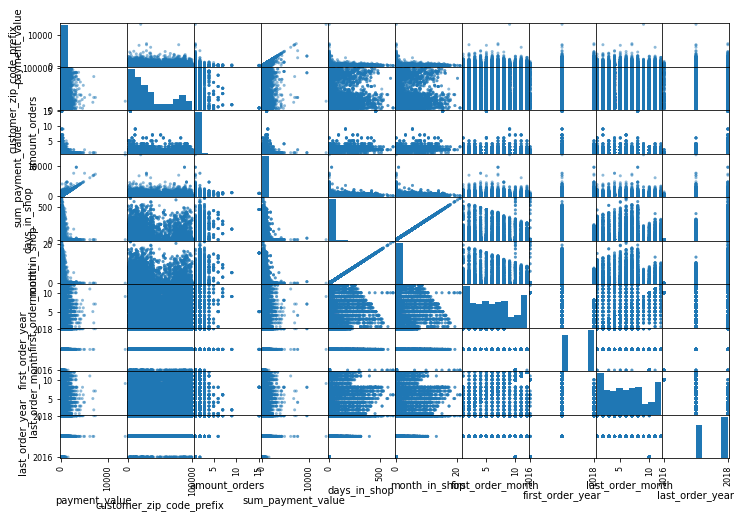

In [60]:
scatter_matrix(df_m, figsize=(12,8))

In [61]:
df_m1.head()

,payment_type,customer_zip_code_prefix,customer_city,customer_state,amount_orders,sum_payment_value,days_in_shop,month_in_shop,first_order_month,first_order_year,last_order_month,last_order_year
0,credit_card,3149,sao paulo,SP,2.0,82.82,27.0,0.9,9.0,2017.0,10.0,2017.0
1,voucher,3149,sao paulo,SP,2.0,82.82,27.0,0.9,9.0,2017.0,10.0,2017.0
4,boleto,47813,barreiras,BA,1.0,141.46,0.0,0.0,7.0,2018.0,7.0,2018.0
5,credit_card,75265,vianopolis,GO,1.0,179.12,0.0,0.0,8.0,2018.0,8.0,2018.0
6,credit_card,59296,sao goncalo do amarante,RN,1.0,72.20,0.0,0.0,11.0,2017.0,11.0,2017.0


In [62]:
#обработка категориальных значений
df_cat_pay=df_m.payment_type
df_cat_pay_encoder, df_m_categories=df_cat_pay.factorize()

In [63]:
df_cat_city=df_m.customer_city
df_cat_city_encoder, df_m_city_categories=df_cat_city.factorize()

In [64]:
df_cat_state=df_m.customer_state
df_cat_state_encoder, df_m_state_categories=df_cat_state.factorize()

In [65]:
#кодировка категорий как векторов в унитарном виде

In [66]:
encoder=OneHotEncoder()

In [67]:
df_cat_pay1=encoder.fit_transform(df_cat_pay_encoder.reshape(-1,1))

In [68]:
df_cat_city1=encoder.fit_transform(df_cat_city_encoder.reshape(-1,1))

In [69]:
df_cat_state1=encoder.fit_transform(df_cat_state_encoder.reshape(-1,1))

In [70]:
df_m.columns

Index(['payment_type', 'payment_value', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'amount_orders', 'sum_payment_value',
       'days_in_shop', 'month_in_shop', 'first_order_month',
       'first_order_year', 'last_order_month', 'last_order_year'],
      dtype='object')

In [71]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [72]:
payment_value_ix, amount_orders_ix=1,3
class CombinedAttributesAdder (BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        avg_check=X[:, payment_value_ix]/X[:, amount_orders_ix]
        return np.c_[X, avg_check]

In [73]:
#выделение числовых аттрибутов
df_m_num=df_m[['payment_value', 'customer_zip_code_prefix',
       'amount_orders', 'sum_payment_value',
       'month_in_shop', 'first_order_month',
       'first_order_year', 'last_order_month', 'last_order_year']].copy()

In [74]:
#выделение категориальных аттрибутов
df_m_cat=df_m[['payment_type','customer_city', 'customer_state']].copy()

In [75]:
num_attribs=list(df_m_num)
cat_attribs=list(df_m_cat)
num_pipeline=Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

In [76]:
class CategoricalEncoder(BaseEstimator, TransformerMixin): 
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown
 
    def fit(self, X, y=None):
        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)
 
        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)
 
        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")
 
        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape
 
        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]
 
        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))
 
        self.categories_ = [le.classes_ for le in self._label_encoders_]
 
        return self
 
    def transform(self, X):
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)
 
        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])
 
            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])
 
        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)
 
        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)
 
        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]
 
        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [77]:
cat_pipeline=Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', CategoricalEncoder(encoding='onehot-dense'))
])

In [78]:
full_pipeline=FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [79]:
#деление данных на обучающую и валидационную выборку
train_set, test_set = train_test_split(df_m, test_size=0.2, random_state=0)

In [80]:
print(len(train_set), "train +", len(test_set), "test")

80780 train + 20195 test


In [81]:
#Выделение меток
df_labels=test_set[['days_in_shop']].copy()

In [82]:
df_prepared=full_pipeline.fit_transform(test_set)

In [83]:
#функция для представления результата перекрестной проверки
def display_scores(scores):
    print('суммы оценок ', scores)
    print('среднее ', scores.mean())
    print('стандартное отклонение ', scores.std())

## Обучение
<a id="5"></a>

In [84]:
#обучение модели с линейной регрессией

In [85]:
lin_reg=LinearRegression()
lin_reg.fit(df_prepared, df_labels)
df_predictions=lin_reg.predict(df_prepared)
lin_mse=mean_squared_error(df_labels, df_predictions)
lin_rmse=np.sqrt(lin_mse)
print(lin_rmse)

3.628242073129893e-13


In [87]:
scores=cross_val_score(lin_reg, df_prepared, df_labels,
                      scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores=np.sqrt(-scores)
display_scores(lin_rmse_scores)

суммы оценок  [1.41371249e-03 9.32159409e-06 6.36494330e-03 2.19570715e-02
 3.60855425e-03 2.87583155e-02 1.48192494e-02 1.16836095e-04
 4.31693230e-03 2.36688047e-02]
среднее  0.01050337410555851
стандартное отклонение  0.010295386739015554


In [88]:
df_labels.mean()

days_in_shop    5.704828
dtype: float64

In [89]:
# обучение с помощью модели DecisionTreeRegressor

In [90]:
tree_reg=DecisionTreeRegressor()
tree_reg.fit(df_prepared, df_labels)
df_predictions_tree=tree_reg.predict(df_prepared)
tree_mse=mean_squared_error(df_labels, df_predictions_tree)
tree_rmse=np.sqrt(tree_mse)
print(tree_rmse)

0.0


In [91]:
scores=cross_val_score(tree_reg, df_prepared, df_labels,
                      scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores=np.sqrt(-scores)
display_scores(tree_rmse_scores)

суммы оценок  [0.42215853 2.6540647  0.39111417 0.26606781 0.88524763 0.21230124
 0.22804812 0.36365325 0.3107772  0.31708804]
среднее  0.6050520679283643
стандартное отклонение  0.7067723578530533
